Author: K. V. Shulga (kirill-shulga@oist.jp)

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import qutip as qu
import pickle
import scipy.sparse as sp

import importlib
import Lib
importlib.reload(Lib)
from Lib import getXops, getEigMel, getEb0, _izj2, find_nearest 
from Lib import getHamiltonian_z, Hamiltonian_z_solve, getHamiltonian_full, Hamiltonian_full_solve 
from Lib import getHamiltonian, Hamiltonian_solve

### Problem parameters

Physical constants definition (in SI units)

In [5]:
from scipy.constants import e, h, hbar, k, m_e, epsilon_0, mu_0

In [6]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
ep4  = 1.0572                          # the relative permittivity of 4He
ep32 = 1.0462                          # the relative permittivity of 3He
ep3  = 1.042                           # the relative permittivity of 3He (in Monakha's book)
ep0  = epsilon_0                       # the electric constant (vacuum permittivity) [C^2 Nm^-2]
mu0  = mu_0                            # the magnetic constant [Tm/A]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]
mb   = 9.2740100783e-24                # Bohr Magneton [J T^-1]

The term $\frac{\Lambda}{z}\Theta(z)$ describes attraction of an electron to a weak image charge inside the liquid, where $\Lambda$ is determined by the dielectric constant of liquid helium ε as

### $\Lambda = \frac{e^2}{16\pi\varepsilon_0}\frac{\varepsilon -1}{\varepsilon+1}$.

In [7]:
l4  = qe**2 / 4 * ( ep4 - 1) / ( ep4 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 4He
l3  = qe**2 / 4 * ( ep3 - 1) / ( ep3 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He (Monakha's book)
l32 = qe**2 / 4 * (ep32 - 1) / (ep32 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He

Define the energy and length scale we choose for $^3$He:

In [8]:
#The whole system uses energy scale of Rydberg_Constant, and length scale of Borh_Radius
    
Rydberg_Constant = me * l4**2/(2 * hb**2)                         # the Rydberg constant for image charge in 3He
Borh_Radius = hb**2/(l4 * me)                                     # the effective Borh radius

# Introduction

## ELECTRONIC STATES IN A FIELD-TRAP ABOVE LIQUID HELIUM SURFACE

The motivation for these notes is to look for quantized states of an electron above liquid helium in a tilted magnetic field such that electrons can be trapped sufficiently far from the liquid helium surface, therefore their coupling to ripplons is significantly reduced.

### A. Potential energy of a surface electron in crossed $E$-$B$ fields


Let us consider an electron on the surface of liquid helium in a tilted magnetic field $B$ and an electric field $E_\perp$ applied perpendicular to the surface but directed in the negative $z$-direction, that is opposite than usual. As previously, the Hamiltonian is given by ([1] A. A. Zadorozhko et al., $\textit{Phys. Rev. B}$ $\textbf{103}$, 054507 (2021)).

### $H =  \hbar\omega_c(a^{\dagger} a+\frac{1}{2}) + H_z' + \frac{\hbar \omega_y}{\sqrt{2}l_B}(a^{\dagger}+a)z$ ,

where $\omega_c=eB_z/m_e$, $\omega_y=eB_y/m_e$, $ l_B=\sqrt{\hbar/eB_z}$, and the renormalized Hamiltonian $H_z'$
of the vertical motion is given by


### $H_z = \frac{p_z^2}{2m_e} - \frac{\Lambda}{z}\Theta(z) -eE_\perp z+ \frac{m_e\omega_y^2z^2}{2}$.

Notice negative sign in the third term corresponding to the vertical electric field pointing in negative $z$-direction. Thus, the potential energy of an electron in $z$-direction is given by

### $U(z) = - \frac{\Lambda}{z} -eE_\perp z+ \frac{m_e\omega_y^2z^2}{2}, ~~~ z>0.$




The plots of $U(z)$ (in units of the effective Rydberg constant $R_e = \Lambda/2 a_B$  versus $z$ (in units of the effective Bohr radius $a_B = \hbar^2/(m_e \Lambda)$ for some typical values of $E_\perp$ and $B_y$ are shown in Fig. 1. The remarkable feature of such a potential is existence (for certain chosen ranges of $E_\perp$ and $B_y$ ) of a local minimum relatively far from the surface of liquid (in addition to the usual minimum at $z = 0$ due to the image potential and surface barrier). Thus, we can expect that electrons can be trapped in such a minimum, with their energy of the vertical motion being quantized in accordance with the principles of quantum mechanics (quantum size effect). As before, such states are expected to be coupled to the states of the in-plane cyclotron motion of electrons.

In [9]:
# introduce coordinate operators z and 1/z as well as Laplacian in z basis
zgrid, z, zgrid_rev, z_rev, Lapz = getXops(2500, zmin = -0.00, zmax = 50, odr = 2)  #2500 points

In [10]:
def Potential(dcStark_shift, l3, z, Omega_y):
    Hz_c =  l3/z                                                # the coulomb interaction term. 2.0=(l3/er/rb)
    Hz_e =  dcStark_shift * z                                   # the linear potential term 
    Hz_q =  0.5 * Omega_y**2 * z*z                              # the quadratic diamagnetic term
    
    H_z = Hz_c + Hz_e + Hz_q   
    
    return H_z

In [11]:
B_y_array = [0.5,0.25,0.25]                                                          # horizontal magnetic field B_y [T] 
Omega_y = np.asarray(B_y_array) * (qe/me*hb/Rydberg_Constant)                        # \Omega_y value
Electric_field_array = [-100,-30,-27]                                                # perpendicular Electric field [V/cm*100]
dcStark_shift = np.asarray(Electric_field_array) * (qe*Borh_Radius/Rydberg_Constant) # additional dc-Stark term

In [12]:
zmin = 0.1 
zmax = 60
z = np.linspace(zmin, zmax, num = 1000)

U_z_array = []

for i in arange(size(B_y_array)):
    U_z = []
    for j in z:
        #2.0 = l3/Rydberg_Constant/Borh_Radius
        U_z.append(Potential(dcStark_shift[i], 2.0, j, Omega_y[i]))
    U_z_array.append(U_z)

In [13]:
p12='figure_5/'                                             #Folder for saving calculation data

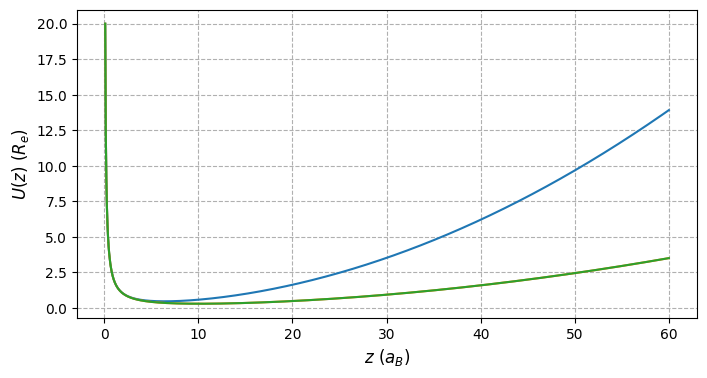

In [14]:
fig, axes = plt.subplots(1,1,figsize=(8, 4))
for i in arange(size(B_y_array)):
    p = plt.plot(z, U_z_array[i])

#axes.set_ylim(0, 400)
#axes.set_xlim(0.25, 3.5)
#axes.invert_yaxis()
#axes.set_title(r'$E_{{\perp}}={}$ V/cm, $B_y ={:.2f}$ T'.format(Electric_field/100, B_y), fontsize = 'small')
axes.set_xlabel(r'$z$ ($a_B$)', fontsize = 'large')
axes.set_ylabel(r'$U(z)$ ($R_e$)', fontsize = 'large')
plt.grid(True, 'major', linestyle = '--')

#fig.savefig(p12 + "U(z)-vs-z,By={:.2f},Ez={:.1f}.pdf".format(B_y_array, Electric_field_array), bbox_inches='tight')
#fig.savefig(p12 + "U(z)-vs-z,By={:.2f},Ez={:.1f}.png".format(B_y_array, Electric_field_array), bbox_inches='tight',dpi = 300)
plt.show()

In [15]:
B_z =np.linspace(0, 3.5, 350)                                     # grid for vertical magnetic field B_z field [T]  
Omega_c = (qe/me*hb/Rydberg_Constant) * B_z                       # grid for different cyclotron frequencies 

In [16]:
# Dimension of the annihilation and creation operator space
dimension = 10                                  
# annihilation and creation operators
a  = sp.diags(np.sqrt(np.arange(dimension - 1) + 1), 1, dtype = np.double)
ad = a.transpose()
# Patricle number operator
N = ad.dot(a)
# Interaction operator
Int = a + ad

In [17]:
Eigenvalues_full = []                                             # Eigenvalues of the full Hamiltonian
Eigenstates_full = []                                             # Eigenstates of the full Hamiltonian

for i in range(len(Omega_c)):
    H_full = getHamiltonian(dcStark_shift, z, Lapz, zgrid_rev, Omega_c[i], Omega_y, N, Int)
    eigenvalues,eigenstates = Hamiltonian_solve(H_full)
    Eigenvalues_full.append(eigenvalues)
    Eigenstates_full.append(eigenstates)

ValueError: operands could not be broadcast together with shapes (3,) (1000,) 

In [173]:
p12='figure_1/'                                                       #Folder for saving calculation data

Eigenvalues_full_stack = np.stack(Eigenvalues_full,axis = 1)
Eigenstates_full_stack = np.stack(Eigenstates_full,axis = 1)

pickle.dump (Eigenvalues_full_stack, open(p12 + "Eigenvalues_full_stack.p", "wb" ))
pickle.dump (Eigenstates_full_stack, open(p12 + "Eigenstates_full_stack.p", "wb" ))

In [174]:
## subtract eigenvalues by the lowest one
Eigenvalues = Eigenvalues_full_stack - Eigenvalues_full_stack[:,0,None]
Frequencies = Eigenvalues * (Rydberg_Constant/h/1e9)

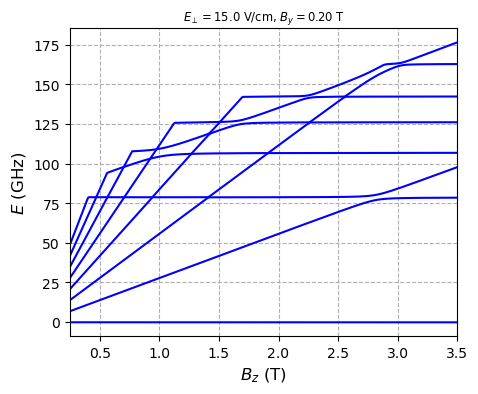

In [177]:
fig, axes = plt.subplots(1,1,figsize=(5, 4))
for i in arange(8):
    #p = plt.scatter(B_z, Frequencies[i], s = 2, color = 'b', marker = 'o', norm = plt.Normalize(0,10))
    p = plt.plot(B_z, Frequencies[i], color = 'b')

#axes.set_ylim(0, 400)
axes.set_xlim(0.25, 3.5)
#axes.invert_yaxis()
axes.set_title(r'$E_{{\perp}}={}$ V/cm, $B_y ={:.2f}$ T'.format(Electric_field/100, B_y), fontsize = 'small')
axes.set_ylabel(r'$E$ (GHz)', fontsize = 'large')
axes.set_xlabel(r'$B_z$ (T)', fontsize = 'large')
plt.grid(True, 'major', linestyle = '--')

fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.pdf".format(B_y, Electric_field), bbox_inches='tight')
fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.png".format(B_y, Electric_field), bbox_inches='tight',dpi = 300)
plt.show()

In [30]:
from matplotlib.colors import ListedColormap
cmap0  = plt.cm.viridis
my_cm  = cmap0(np.flip(np.arange(cmap0.N)))
my_cm[:,-1] = np.linspace(0, 1, cmap0.N)**.5
my_cm  = ListedColormap(my_cm)

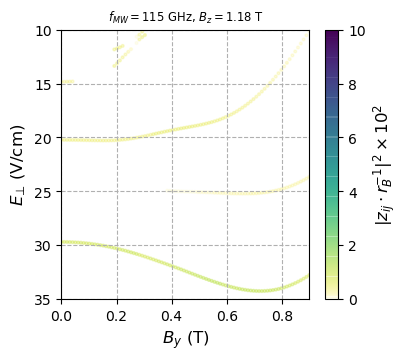

In [31]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (4, 3.5))
pic = plt.scatter(dots[:,0], dots[:,1]/100, s = 4, c = z2s * 100, cmap = my_cm, marker = 'o',norm = plt.Normalize(0,10))
ax.set_ylim(10, 35)
ax.set_xlim(0, .9)
ax.invert_yaxis()
ax.set_title(r'$f_{{MW}}={}$ GHz, $B_z ={:.2f}$ T'.format(Frequency_0, B_z),fontsize='small')
plt.ylabel(r'$E_\bot$ (V/cm)', fontsize='large')
plt.xlabel(r'$B_y$ (T)', fontsize='large')
plt.grid(True, 'major', linestyle='--')

cb = fig.colorbar(pic)
cb.set_label(r'$|z_{{ij}} \cdot r_B^{-1} |^2  \times10^{2}$', fontsize='large') #r_B^{{-2}}

fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.pdf".format(B_z,Frequency_0), bbox_inches='tight')
fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.png".format(B_z,Frequency_0), bbox_inches='tight',dpi = 300)
plt.show()
#plt.close()

In [17]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [18]:
mpl.style.use('default')